In [6]:
# Cell 1: 라이브러리 & 설정
import os
import json
import re
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoTokenizer, AutoModelForCausalLM

# ⚙️ 설정값
INPUT_FILE = "project_full_context.txt"
OUTPUT_JSON = "project_flows.json"
MODEL_ID = "Qwen/Qwen2.5-Coder-1.5B-Instruct"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 실행 환경: {device.upper()}")

🚀 실행 환경: CUDA


In [7]:
# Cell 2: 모델 로딩
print(f"🔄 모델 로딩 시작... ({MODEL_ID})")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

print("✅ 모델 장착 완료!")

🔄 모델 로딩 시작... (Qwen/Qwen2.5-Coder-1.5B-Instruct)
✅ 모델 장착 완료!


In [8]:
# Cell 3: 프롬프트 정의
SYSTEM_PROMPT = """
You are a 'Code Flow Visualization Expert' and Senior Developer.
Analyze the provided code and extract **execution flows** (Call Graph).

### INSTRUCTIONS
1. Identify which function calls which function.
2. Extract the **exact code snippet** where each call happens.
3. Keep descriptions simple for beginners.
4. MUST return valid JSON with at least one flow if any function calls exist.

### OUTPUT FORMAT (JSON ONLY - NO MARKDOWN)
{
  "flows": [
    {
      "flow_name": "Flow Name",
      "sequence": [
        {
          "step": 1,
          "type": "Function Call",
          "description": "Simple explanation",
          "from": {
            "focus_word": "caller_function",
            "code_snippet": "exact_code_line"
          },
          "to": {
            "focus_word": "called_function",
            "code_snippet": "target_function_def"
          }
        }
      ]
    }
  ]
}

### RULES
- Output ONLY valid JSON (no markdown, no backticks).
- If no function calls found, return empty flows: {"flows": []}
- Each flow_name must be descriptive (e.g., "signup_user_creation")
"""

CHUNK_PROMPT = """
Analyze this code file and extract function calls (call graphs).
Focus on: {user_query}

File: {filename}
```
{code_snippet}
```

Return ONLY valid JSON. No markdown, no explanation.
"""

print("✅ 프롬프트 정의 완료")

✅ 프롬프트 정의 완료


In [9]:
# Cell 4: 분석 함수 (청크)
def analyze_chunk(filename, code_snippet, user_query):
    """
    개별 파일/청크를 LLM으로 분석
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": CHUNK_PROMPT.format(
                filename=filename,
                code_snippet=code_snippet[:3000],
                user_query=user_query
            )
        }
    ]

    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)

    print(f"  🔍 분석 중: {filename}")

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        temperature=0.1,
        top_p=0.95,
        do_sample=False
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    clean_text = response_text.strip()
    clean_text = re.sub(r"^```(json)?", "", clean_text, flags=re.MULTILINE).strip()
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE).strip()

    try:
        result = json.loads(clean_text)
        flows = result.get("flows", [])
        print(f"    ✅ {len(flows)}개 flow 발견")
        return result
    except json.JSONDecodeError as e:
        print(f"    ⚠️ JSON 파싱 실패")
        return {"flows": []}

print("✅ analyze_chunk 함수 정의 완료")

✅ analyze_chunk 함수 정의 완료


In [10]:
# Cell 5: 파일 분할 및 청크 분석 함수
def parse_files_from_context(code_context):
    """
    project_full_context.txt에서 파일 단위로 분할
    """
    files = {}
    pattern = r"=== FILE_PATH:\s*(.+?)\s*===\n(.*?)(?===\s*FILE_PATH:|$)"
    matches = re.finditer(pattern, code_context, re.DOTALL)
    
    for match in matches:
        filename = match.group(1).strip()
        content = match.group(2).strip()
        files[filename] = content
    
    if not files:
        files["<full_context>"] = code_context
    
    return files


def analyze_code_flow_chunked(user_query):
    """
    파일 단위 청크 분석 + 통합
    """
    if not os.path.exists(INPUT_FILE):
        print(f"❌ '{INPUT_FILE}' 파일이 없습니다.")
        return False

    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        code_context = f.read()

    files = parse_files_from_context(code_context)
    print(f"📂 발견된 파일: {len(files)}개")

    all_flows = []
    for filename, content in files.items():
        if len(content.strip()) < 50:
            print(f"  ⏭️  스킵: {filename}")
            continue

        result = analyze_chunk(filename, content, user_query)
        flows = result.get("flows", [])
        
        for flow in flows:
            flow["source_file"] = filename
            all_flows.append(flow)

    integrated_data = {"flows": all_flows, "total_flows": len(all_flows)}
    
    with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
        json.dump(integrated_data, f, ensure_ascii=False, indent=2)

    print(f"✅ 통합 JSON 저장: {OUTPUT_JSON}")
    print(f"📊 총 {len(all_flows)}개 flow 추출됨")
    return True

print("✅ 분석 함수 정의 완료")

✅ 분석 함수 정의 완료


In [12]:
# Cell 6: 시각화 함수
def visualize_flow_arrows_enhanced():
    """
    JSON 데이터를 향상된 이미지로 시각화
    """
    if not os.path.exists(OUTPUT_JSON):
        print("❌ 시각화할 JSON 파일이 없습니다.")
        return None

    try:
        with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
            data = json.load(f)
            flows = data.get("flows", [])
    except json.JSONDecodeError:
        print("⚠️ JSON 파싱 실패")
        return None

    if not flows:
        print("⚠️ 시각화할 flow가 없습니다.")
        return None

    img_width = 1400
    flow_height = 150
    img_height = max(800, len(flows) * flow_height + 200)
    
    img = Image.new('RGB', (img_width, img_height), color='#1e1e1e')
    draw = ImageDraw.Draw(img)
    
    try:
        font_small = ImageFont.truetype("arial.ttf", 12)
        font_medium = ImageFont.truetype("arial.ttf", 14)
        font_title = ImageFont.truetype("arial.ttf", 18)
    except:
        font_small = ImageFont.load_default()
        font_medium = font_small
        font_title = font_small

    draw.text((50, 30), "📊 Code Flow Visualization", fill="#FFFFFF", font=font_title)
    draw.text((50, 60), f"Total Flows: {len(flows)}", fill="#ABB2BF", font=font_medium)
    
    colors = ["#FF5555", "#50FA7B", "#8BE9FD", "#FFB86C", "#BD93F9", "#FF79C6"]
    y_offset = 120

    print(f"🎨 시각화 생성 중... ({len(flows)} flows)")

    for flow_idx, flow in enumerate(flows):
        flow_color = colors[flow_idx % len(colors)]
        
        draw.rectangle([40, y_offset-10, img_width-40, y_offset+flow_height-20], 
                       outline=flow_color, width=2)
        
        flow_name = flow.get('flow_name', 'Unknown')
        source_file = flow.get('source_file', 'N/A')
        draw.text((60, y_offset+5), f"Flow {flow_idx+1}: {flow_name}", 
                  fill=flow_color, font=font_medium)
        draw.text((60, y_offset+30), f"📁 {source_file}", 
                  fill="#ABB2BF", font=font_small)
        
        sequence = flow.get('sequence', [])
        
        step_y = y_offset + 60
        for i, step in enumerate(sequence):
            step_color = colors[(flow_idx + i) % len(colors)]
            
            f_word = step['from'].get('focus_word', '?')
            t_word = step['to'].get('focus_word', '?')
            desc = step.get('description', '')[:60]
            
            draw.text((70, step_y), f"{i+1}.", fill=step_color, font=font_medium)
            draw.text((100, step_y), f"{f_word}", fill="#50FA7B", font=font_small)
            draw.text((220, step_y), "→", fill=step_color, font=font_medium)
            draw.text((245, step_y), f"{t_word}", fill="#8BE9FD", font=font_small)
            draw.text((400, step_y), desc, fill="#ABB2BF", font=font_small)
            
            step_y += 25
        
        y_offset += flow_height

    return img

print("✅ 시각화 함수 정의 완료")

✅ 시각화 함수 정의 완료


In [11]:
# Cell 7: 코드 분석 실행 (JSON + 텍스트 설명)
print("🚀 청크 기반 분석 시작...")
success = analyze_code_flow_chunked(user_query="코드의 함수 호출 흐름")

if success:
    with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print("\n📋 === 추출된 흐름 (JSON) ===\n")
    print(json.dumps(data, ensure_ascii=False, indent=2))
    
    print(f"\n✅ JSON 저장 완료: {OUTPUT_JSON}")
    print(f"📊 총 {data.get('total_flows', 0)}개 flow 발견")
    
    for idx, flow in enumerate(data.get('flows', []), 1):
        print(f"\n[Flow {idx}] {flow.get('flow_name', 'Unknown')}")
        print(f"  파일: {flow.get('source_file', 'Unknown')}")
        sequence = flow.get('sequence', [])
        print(f"  단계: {len(sequence)}개")
        for step in sequence:
            from_word = step.get('from', {}).get('focus_word', '?')
            to_word = step.get('to', {}).get('focus_word', '?')
            desc = step.get('description', '')
            print(f"    → {from_word} → {to_word}: {desc}")
else:
    print("❌ 분석 실패")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 청크 기반 분석 시작...
📂 발견된 파일: 1개
  🔍 분석 중: <full_context>
    ✅ 1개 flow 발견
✅ 통합 JSON 저장: project_flows.json
📊 총 1개 flow 추출됨

📋 === 추출된 흐름 (JSON) ===

{
  "flows": [
    {
      "flow_name": "Signup User Creation",
      "sequence": [
        {
          "step": 1,
          "type": "Function Call",
          "description": "Create JWT Token",
          "from": {
            "focus_word": "createJwtToken",
            "code_snippet": "await createJwtToken(id)"
          },
          "to": {
            "focus_word": "res.send",
            "code_snippet": "res.send({ token: jwtToken });"
          }
        },
        {
          "step": 2,
          "type": "Function Call",
          "description": "Find User by UserID",
          "from": {
            "focus_word": "signup",
            "code_snippet": "const found = await authRepository.findByUserid(userid);"
          },
          "to": {
            "focus_word": "if",
            "code_snippet": "if (found) {"
          }
        },


🎨 시각화 시작...
🎨 시각화 생성 중... (1 flows)


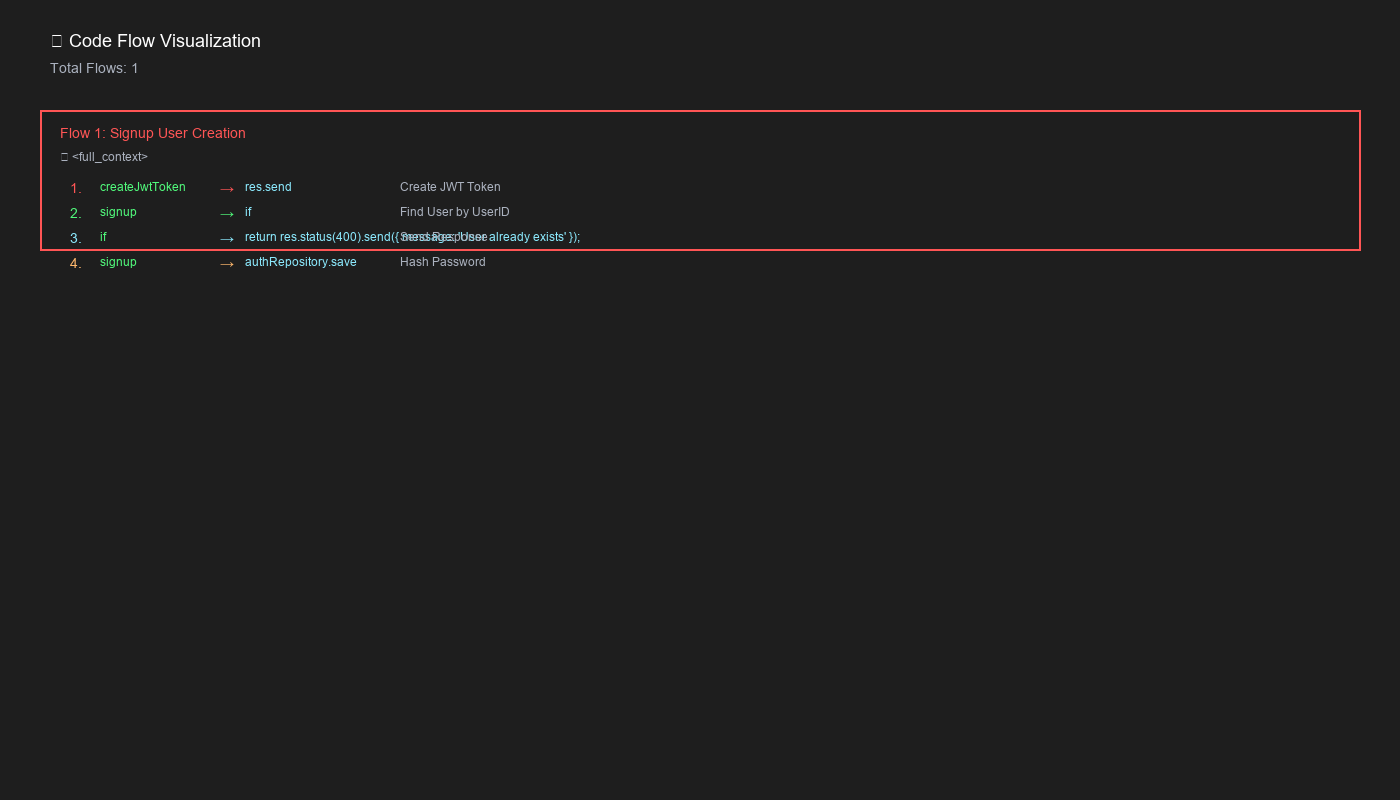

✨ 시각화 완료! 저장: final_flow_chart_chunked.png


In [13]:
# Cell 8: 시각화 실행 (이미지 생성)
print("🎨 시각화 시작...")
result_img = visualize_flow_arrows_enhanced()

if result_img:
    display(result_img)
    result_img.save("final_flow_chart_chunked.png")
    print("✨ 시각화 완료! 저장: final_flow_chart_chunked.png")
else:
    print("❌ 시각화 생성 실패")

In [5]:
# 디버깅: 입력 파일 확인
print("🔍 디버깅: 입력 파일 상태 확인")
print(f"INPUT_FILE 존재: {os.path.exists(INPUT_FILE)}")

if os.path.exists(INPUT_FILE):
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        content = f.read()
    
    print(f"파일 크기: {len(content)} bytes")
    print(f"첫 500자:\n{content[:500]}")
    
    # 파일 분할 테스트
    files = parse_files_from_context(content)
    print(f"\n파일 분할 결과: {len(files)}개 파일")
    for fname, fcontent in files.items():
        print(f"  - {fname}: {len(fcontent)} chars")
else:
    print("❌ project_full_context.txt 파일이 없습니다!")

🔍 디버깅: 입력 파일 상태 확인
INPUT_FILE 존재: True
파일 크기: 12721 bytes
첫 500자:
# Project Source Code Integration
# Target Directory: C:\Pyg\X\Server

### FILE: C:\Pyg\X\Server\app.mjs
------------------------------
import express from "express";
import postsRouter from "./router/posts.mjs";
import authRouter from "./router/auth.mjs";
import { config } from "./config.mjs";
import { connectDB } from "./db/database.mjs";
import cors from "cors";

// 미들웨어 순서가 맞아야됨
const app = express();

app.use(express.json());
app.

파일 분할 결과: 1개 파일
  - <full_context>: 12721 chars
